In [1]:
import tensorflow as tf
import awswrangler as wr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from typing import List
import pandas as pd
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


2023-04-07 10:53:08.385068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 10:53:08.392868: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 10:53:08.474827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 10:53:08.476173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 10:53:09.466329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Read data

In [2]:
df = wr.s3.read_parquet("s3://citroen-cost-prediction/proccesed-data").drop_duplicates(
    ignore_index=True
)


# Utility functions

In [3]:
class ColumnDropperTransformer(TransformerMixin):
    def __init__(self, columns: List[str]):
        self.columns = columns

    def transform(self, X: pd.DataFrame, y=None):
        return X.drop(columns=self.columns)

    def fit(self, X: pd.DataFrame, y=None):
        return self


In [4]:
def create_model():
    N = 20
    # create model
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            N,
            input_dim=3,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            N,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
        )
    )
    model.add(
        tf.keras.layers.Dense(
            1, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)
        )
    )
    # Compile model
    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
    return model


In [5]:
def make_split(
    df: pd.DataFrame,
    random_state: int = 42,
    target: str = "coste",
    test_size: float = 0.3,
):
    X = df.drop(columns=target)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Training data size: {X_train.shape}\nTest data size: {X_test.shape}")
    print("Trainging ")
    return X_train, X_test, y_train, y_test


In [6]:
dropper = ColumnDropperTransformer(
    columns=[
        "direccion_origen",
        "direccion_destino",
        "fecha",
        "hora_salida",
        "hora_llegada",
        "consumo_medio",
    ]
)
scaler = StandardScaler()
model = KerasRegressor(model=create_model, epochs=300, batch_size=10)
pipe = Pipeline(steps=[("dropper", dropper), ("scaler", scaler), ("model", model)])


In [7]:
X_train, X_test, y_train, y_test = make_split(df=df, target="coste", test_size=0.2)


Training data size: (817, 9)
Test data size: (205, 9)
Trainging 


In [8]:
pipe.fit(
    X_train,
    y_train,
    model__validation_split=0.2,
    model__callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)],
)


Epoch 1/300
66/66 [==============================] - 1s 6ms/step - loss: 21.3636 - mse: 20.4252 - val_loss: 29.8683 - val_mse: 29.1785
Epoch 2/300
66/66 [==============================] - 0s 3ms/step - loss: 20.9402 - mse: 20.4252 - val_loss: 29.5350 - val_mse: 29.1785
Epoch 3/300
66/66 [==============================] - 0s 2ms/step - loss: 20.6737 - mse: 20.4252 - val_loss: 29.3331 - val_mse: 29.1785
Epoch 4/300
66/66 [==============================] - 0s 2ms/step - loss: 20.4110 - mse: 20.3130 - val_loss: 28.7420 - val_mse: 28.6856
Epoch 5/300
66/66 [==============================] - 0s 2ms/step - loss: 19.5641 - mse: 19.5188 - val_loss: 26.8381 - val_mse: 26.7901
Epoch 6/300
66/66 [==============================] - 0s 2ms/step - loss: 16.9982 - mse: 16.9399 - val_loss: 22.4254 - val_mse: 22.3477
Epoch 7/300
66/66 [==============================] - 0s 3ms/step - loss: 13.9421 - mse: 13.8495 - val_loss: 14.8339 - val_mse: 14.7241
Epoch 8/300
66/66 [==============================] - 0s

Pipeline(steps=[('dropper',
                 <__main__.ColumnDropperTransformer object at 0x7f92c241a830>),
                ('scaler', StandardScaler()),
                ('model',
                 KerasRegressor(batch_size=10, epochs=300, model=<function create_model at 0x7f92c3d3d090>))])

In [9]:
pipe.score(X_test, y_test)


21/21 [==============================] - 0s 2ms/step


0.9722933664413795

In [10]:
def make_plots(model, X, y):
    distancia = X.distancia.to_numpy()
    plt.figure(figsize=(10, 8))
    plt.title("Performance")
    plt.xlabel("Distancia")
    plt.ylabel("Coste")
    y_pred = model.predict(X)
    plt.scatter(distancia, y_pred, label="pred", marker=".", alpha=0.3)
    plt.scatter(distancia, y, label="true", marker=".", alpha=0.3)
    plt.legend()
    plt.show()


21/21 [==============================] - 0s 2ms/step


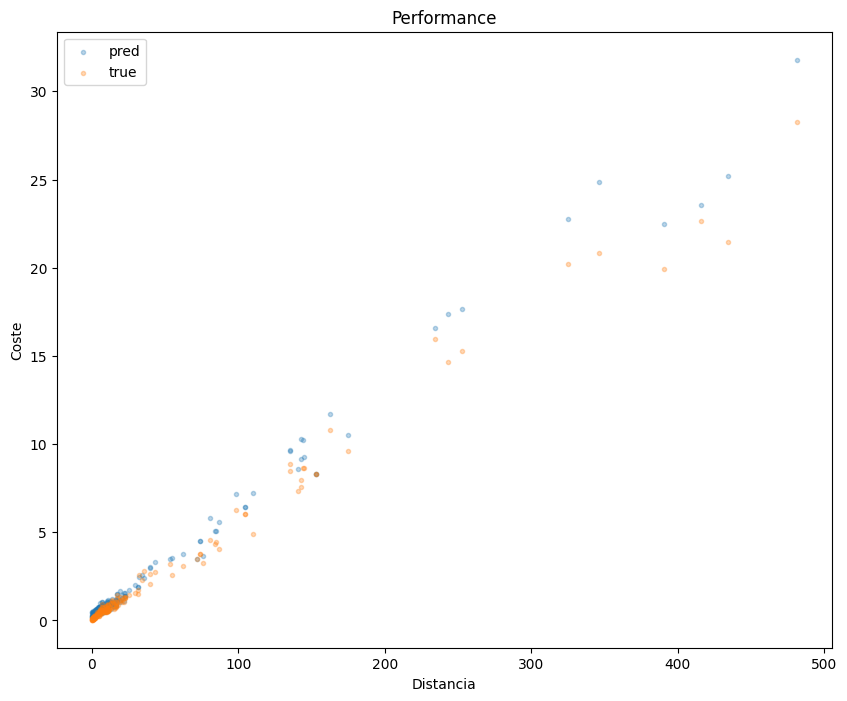

In [11]:
make_plots(pipe, X_test, y_test)


In [12]:
def predict_single(distancia: float, kilometraje: int, precio_carburante: float):
    X = pd.DataFrame(
        dict(
            distancia=[distancia],
            kilometraje=[kilometraje],
            precio_carburante=[precio_carburante],
        )
    )
    return float(np.squeeze(pipe[1:].predict(X)))


In [13]:
predict_single(distancia=4.5, kilometraje=69700, precio_carburante=0.5)


1/1 [==============================] - 0s 20ms/step


0.1935589760541916

In [14]:
def max_error(X_test, y_test):
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    diff = np.abs(y_test - pipe.predict(X_test))
    argmax = np.argmax(diff)
    max_err = diff[argmax]
    y_max = y_test[argmax]
    print(f"Maximum error reached in test set: {max_err}. Real value: {y_max}")


def mean_error(X_test, y_test):
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    mean_err = np.mean(y_test - pipe.predict(X_test))
    print(f"Mean error in test set: {mean_err}")


max_error(X_test, y_test)
mean_error(X_test, y_test)


21/21 [==============================] - 0s 2ms/step
Maximum error reached in test set: 4.005829467773438. Real value: 20.86
21/21 [==============================] - 0s 2ms/step
Mean error in test set: -0.37867774242017327
